In [1]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import tf_keras as keras # need keras 2 to fit Lattice model
from tf_keras.models import Sequential, Model
from tf_keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from tf_keras.constraints import Constraint
from tf_keras.callbacks import EarlyStopping
from tf_keras.initializers import Zeros, Constant
from tf_keras.optimizers import Adam, Nadam, RMSprop
from tf_keras.models import clone_model
import keras_tuner as kt
from tf_keras import backend as K
from tf_keras import regularizers
from tf_keras.utils import plot_model
from tf_keras.losses import Poisson, Loss
from tf_keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [2]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [3]:
#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_high_var.csv")

In [4]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.384709,0.070514,0.245303,-0.564460,-0.450318,0.531209,-0.139983,-0.999956,0.009359,484.018506
1,0.430379,-0.875990,0.808088,0.648436,0.174499,-0.765558,-0.898927,-0.168761,0.081209,-0.263657,8.205027
2,0.205527,0.977570,0.004793,-0.431433,0.975227,0.473320,0.995090,0.794291,-0.802390,-0.861454,0.001452
3,0.089766,0.438181,-0.798260,0.756793,0.901734,0.431272,-0.864656,0.512576,0.085770,-0.545924,1.234774
4,-0.152690,0.515139,0.055164,0.282328,-0.314057,0.639535,-0.581069,0.940797,-0.261984,-0.425629,1748.575867
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.092658,0.451842,0.805609,-0.262674,0.758215,-0.205461,0.443849,-0.978784,0.740276,0.645713,1.171281
49996,0.386621,0.015041,-0.538708,-0.389854,-0.632906,-0.311577,0.027367,-0.845545,0.010439,0.868084,173.006198
49997,-0.532650,0.620266,0.162028,-0.570751,0.005453,0.235543,0.099723,0.663875,0.851769,0.066433,15.210745
49998,0.661848,0.102065,-0.526136,-0.408447,0.373860,-0.328123,0.756798,-0.514888,0.618938,0.761628,420.616658


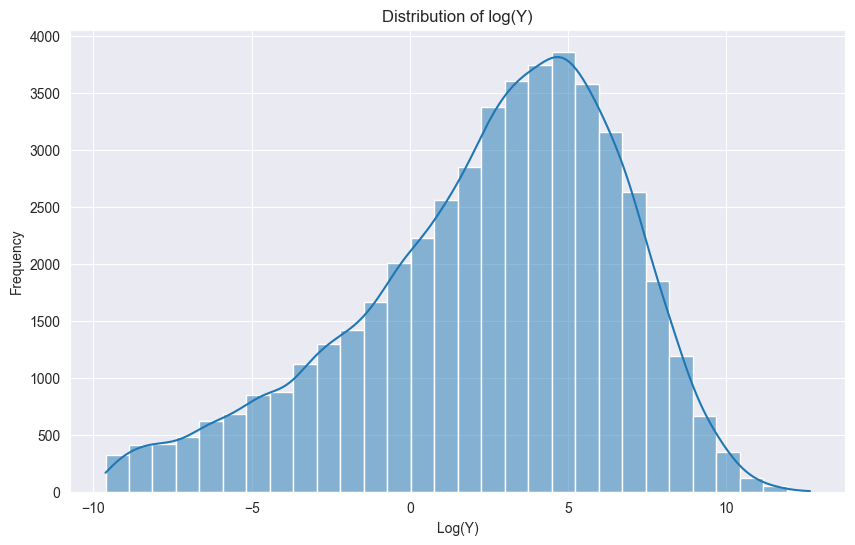

In [5]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [6]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
all_vars.remove(target_var) # store all input features
cat_vars = [] # categorical features

In [7]:
############################ 1. MAIN EFFECT SELECTION ############################

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[all_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [8]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_first_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_first_layer - i*int(units_first_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

In [9]:
# -------------------------- custom loss function --------------------------
def gamma_nll(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-7, 1e30)
    return K.mean(y_true/y_pred - K.log(y_true/y_pred))

In [10]:
#-------------------------- prepare the data for NAM --------------------------
X_train_split = []
X_val_split = []
for i in range(X_train.shape[1]):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])

In [11]:
# -------------------------- Fit an ensemble of 10 NAMs --------------------------
seed = 0
num_models = 10
all_variance = []

# create ensemble and get subnet variance
for i in range(num_models):
    
    keras.utils.set_random_seed(seed)

    # -------------------------- define model architecture --------------------------
    inputs = []  # input layers
    sub_outputs_main = []  # main effect subnet output
    num_neurons_main = 20
    num_layers_main = 2
    activation = 'leaky_relu'
    keypoints = 10
    monotonicity_list = {"X3" : "decreasing"} # either "increasing", "decreasing", or "none"

    # main effect
    for name in all_vars:

        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetworks for main effects
        if name in cat_vars: # categorical variables
            # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs_main.append(mean_layer)
        elif name in monotonicity_list: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
                monotonicity = monotonicity_list[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs_main.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs_main.append(sub_output)

    # combine subnets' outputs and create model
    main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
    final_output = Dense(1, activation = "exponential", name = "main_output")(main_subnets)
    model_all_vars = Model(inputs = inputs, outputs = final_output)

    # -------------------------- fit the model --------------------------
    model_all_vars.compile(optimizer = "adam", loss = gamma_nll, metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    es = EarlyStopping(restore_best_weights = True, patience = 10)
    model_all_vars.fit(X_train_split, y_train, epochs = 5_000, \
        callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val), verbose = 0)
    

    # -------------------------- quantify variable importance --------------------------
    main_output_layer = model_all_vars.get_layer("main_subnet")  # Get the subnet output layer
    main_model = Model(inputs = model_all_vars.inputs, outputs = main_output_layer.output)
    main_output_values = main_model.predict(X_train_split, batch_size = 5_000)

    # Get the variance of each subnetwork across all data points
    subnet_weights = model_all_vars.get_layer("main_output").get_weights()[0]
    subnet_variance = [np.var(main_output_values[:, i])*subnet_weights[i][0]**2 for i in range(main_output_values.shape[1])]
    all_variance.append(subnet_variance)

    # update seed
    seed += 1

6/6 [==============================] - 0s 4ms/step


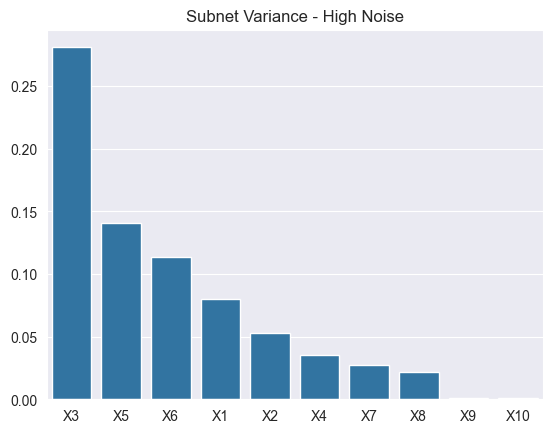

In [12]:
# -------------------------- plot the variable importance --------------------------
average_variances = np.mean(all_variance, axis = 0) # get the average variance

# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": all_vars, "Subnet Variance": average_variances})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
# plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance - High Noise")
plt.xlabel("")
plt.ylabel("")

plt.rcParams["figure.figsize"] = (5, 2) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()

In [13]:
#-------------------------- reset keras seed --------------------------
keras.utils.set_random_seed(seed_value)

In [14]:
############################ 1. MODEL FITTING ############################

# extract important variables
imp_vars = [f"X{i}" for i in range(1,9)]

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[imp_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [15]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 20
num_layers_main = 2
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"X3" : "decreasing"} # either "increasing", "decreasing", or "none"

# main effect
for name in imp_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
        sub_outputs_main.append(mean_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        sub_outputs_main.append(mean_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
final_output = Dense(1, activation = "exponential", name = "main_output")(main_subnets)

# final model
model_main_effect = Model(inputs = inputs, outputs = final_output)

In [16]:
# -------------------------- compile and fit --------------------------
# create training & validation data consistent with the model architecture
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])
    X_test_split.append(X_test.iloc[:, i])

# compile and fit
model_main_effect.compile(optimizer = "adam", loss = gamma_nll, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 20)
%time hist_main = model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
29/29 [==============================] - 1s 12ms/step - loss: 1546.1914 - root_mean_squared_error: 5252.2041 - val_loss: 777.6448 - val_root_mean_squared_error: 6057.8516
Epoch 2/5000
29/29 [==============================] - 0s 4ms/step - loss: 962.4095 - root_mean_squared_error: 5252.2529 - val_loss: 748.3478 - val_root_mean_squared_error: 6057.8457
Epoch 3/5000
29/29 [==============================] - 0s 4ms/step - loss: 724.9839 - root_mean_squared_error: 5252.2749 - val_loss: 694.1139 - val_root_mean_squared_error: 6057.8301
Epoch 4/5000
29/29 [==============================] - 0s 5ms/step - loss: 620.2855 - root_mean_squared_error: 5252.2632 - val_loss: 663.4609 - val_root_mean_squared_error: 6057.8188
Epoch 5/5000
29/29 [==============================] - 0s 4ms/step - loss: 562.4840 - root_mean_squared_error: 5252.2363 - val_loss: 598.7055 - val_root_mean_squared_error: 6057.7935
Epoch 6/5000
29/29 [==============================] - 0s 4ms/step - loss: 507.7757 - roo

In [17]:
# -------------------------- get validation loss --------------------------
main_val_loss, main_rmse = model_main_effect.evaluate(X_val_split, y_val, verbose = False) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")
print(f"Validation RMSE for main effect: {main_rmse}")

Validation loss for main effect: 4.984879493713379
Validation RMSE for main effect: 5937.130859375


In [18]:
############################   preparation for interaction selection   ############################
global_layers = ["main_subnet", "main_output", "interaction_output", "final_output"] # these layers are always trainable
imp_vars = [f"X{i}" for i in range(1,9)] # important variables
num_layers_interaction = 10 # number of layers for each interaction effect
num_neurons_interaction = 100 # number of neurons per dense layer for each interaction effect
keypoints = 20
lattice_sizes_pairwise = {}
for var in imp_vars:
    if var in cat_vars:
        lattice_sizes_pairwise[var] = X_train[var].nunique()
    else:
        lattice_sizes_pairwise[var] = 8

In [19]:
# -------------------------- create calibrator for lattice layer --------------------------
def add_calibrate_layer(var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = data[var].nunique(),
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[var].min(), data[var].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise"
            )
    return calibrator_layer

In [20]:
############################ select interaction effect ############################

interactions = combinations(imp_vars, 2)
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_main_effect) # clone the main effect model
    model_main_cloned.build(model_main_effect.input_shape)
    model_main_cloned.set_weights(model_main_effect.get_weights()) # copy the weights


    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[imp_vars.index(var1)]
    var2_input = model_main_cloned.inputs[imp_vars.index(var2)]

    # Lattice model if the pair contains a monotonic variable
    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # create calibrator_layer
        calibrator_var1 = add_calibrate_layer(var1, X_train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars)
        calibrator_var2 = add_calibrate_layer(var2, X_train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars)
        calibrator_layer_var1 = calibrator_var1(var1_input)
        calibrator_layer_var2 = calibrator_var2(var2_input)
        
        # lattice
        lattice_inputs.append(calibrator_layer_var1)
        lattice_inputs.append(calibrator_layer_var2)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_pairwise[var1],lattice_sizes_pairwise[var2]], 
                            monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
    else:
        # Subnetwork if the pair contains no monotonic variables
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_output = pairwise_subnet(pairwise_input_layer)

    # final output
    interaction_subnet_output = Activation('exponential',
                        name = "interaction_output")(pairwise_output)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)


    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False

    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = 'adam', 
                        loss = gamma_nll, 
                        metrics = [gamma_nll, RootMeanSquaredError()])
    es = EarlyStopping(patience = 25, restore_best_weights = True)
    model_pairwise.fit(X_train_split, y_train, epochs = 5_000, \
                            callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))
    _, gamma_log_metric, _ = model_pairwise.evaluate(X_val_split, y_val, batch_size = X_val_split[0].shape[0])
    interaction_loss[f"{var1}_{var2}"] = gamma_log_metric # add to the val loss list

Epoch 1/5000
29/29 [==============================] - 1s 19ms/step - loss: 5.0648 - gamma_nll: 5.0628 - root_mean_squared_error: 5146.6104 - val_loss: 4.9880 - val_gamma_nll: 5.0053 - val_root_mean_squared_error: 5940.4150
Epoch 2/5000
29/29 [==============================] - 0s 9ms/step - loss: 5.0444 - gamma_nll: 5.0437 - root_mean_squared_error: 5141.5566 - val_loss: 5.0434 - val_gamma_nll: 5.0658 - val_root_mean_squared_error: 5957.3828
Epoch 3/5000
29/29 [==============================] - 0s 8ms/step - loss: 5.0468 - gamma_nll: 5.0472 - root_mean_squared_error: 5145.5298 - val_loss: 4.9919 - val_gamma_nll: 5.0076 - val_root_mean_squared_error: 5947.0278
Epoch 4/5000
29/29 [==============================] - 0s 10ms/step - loss: 5.0581 - gamma_nll: 5.0585 - root_mean_squared_error: 5145.3691 - val_loss: 5.0094 - val_gamma_nll: 5.0255 - val_root_mean_squared_error: 5959.6470
Epoch 5/5000
27/29 [==========================>...] - ETA: 0s - loss: 5.0548 - gamma_nll: 5.0548 - root_mean_s

29/29 [==============================] - 0s 16ms/step - loss: 5.0488 - gamma_nll: 5.0478 - root_mean_squared_error: 5144.2368 - val_loss: 5.0320 - val_gamma_nll: 5.0460 - val_root_mean_squared_error: 5972.6636
Epoch 6/5000
29/29 [==============================] - 0s 12ms/step - loss: 5.0413 - gamma_nll: 5.0431 - root_mean_squared_error: 5143.8369 - val_loss: 5.0045 - val_gamma_nll: 5.0199 - val_root_mean_squared_error: 5958.9419
Epoch 7/5000
29/29 [==============================] - 0s 11ms/step - loss: 5.0437 - gamma_nll: 5.0436 - root_mean_squared_error: 5144.1709 - val_loss: 4.9929 - val_gamma_nll: 5.0075 - val_root_mean_squared_error: 5944.4019
Epoch 8/5000
29/29 [==============================] - 0s 10ms/step - loss: 5.0404 - gamma_nll: 5.0380 - root_mean_squared_error: 5137.2876 - val_loss: 5.0114 - val_gamma_nll: 5.0259 - val_root_mean_squared_error: 5955.0522
Epoch 9/5000
29/29 [==============================] - 0s 11ms/step - loss: 5.0452 - gamma_nll: 5.0443 - root_mean_squared

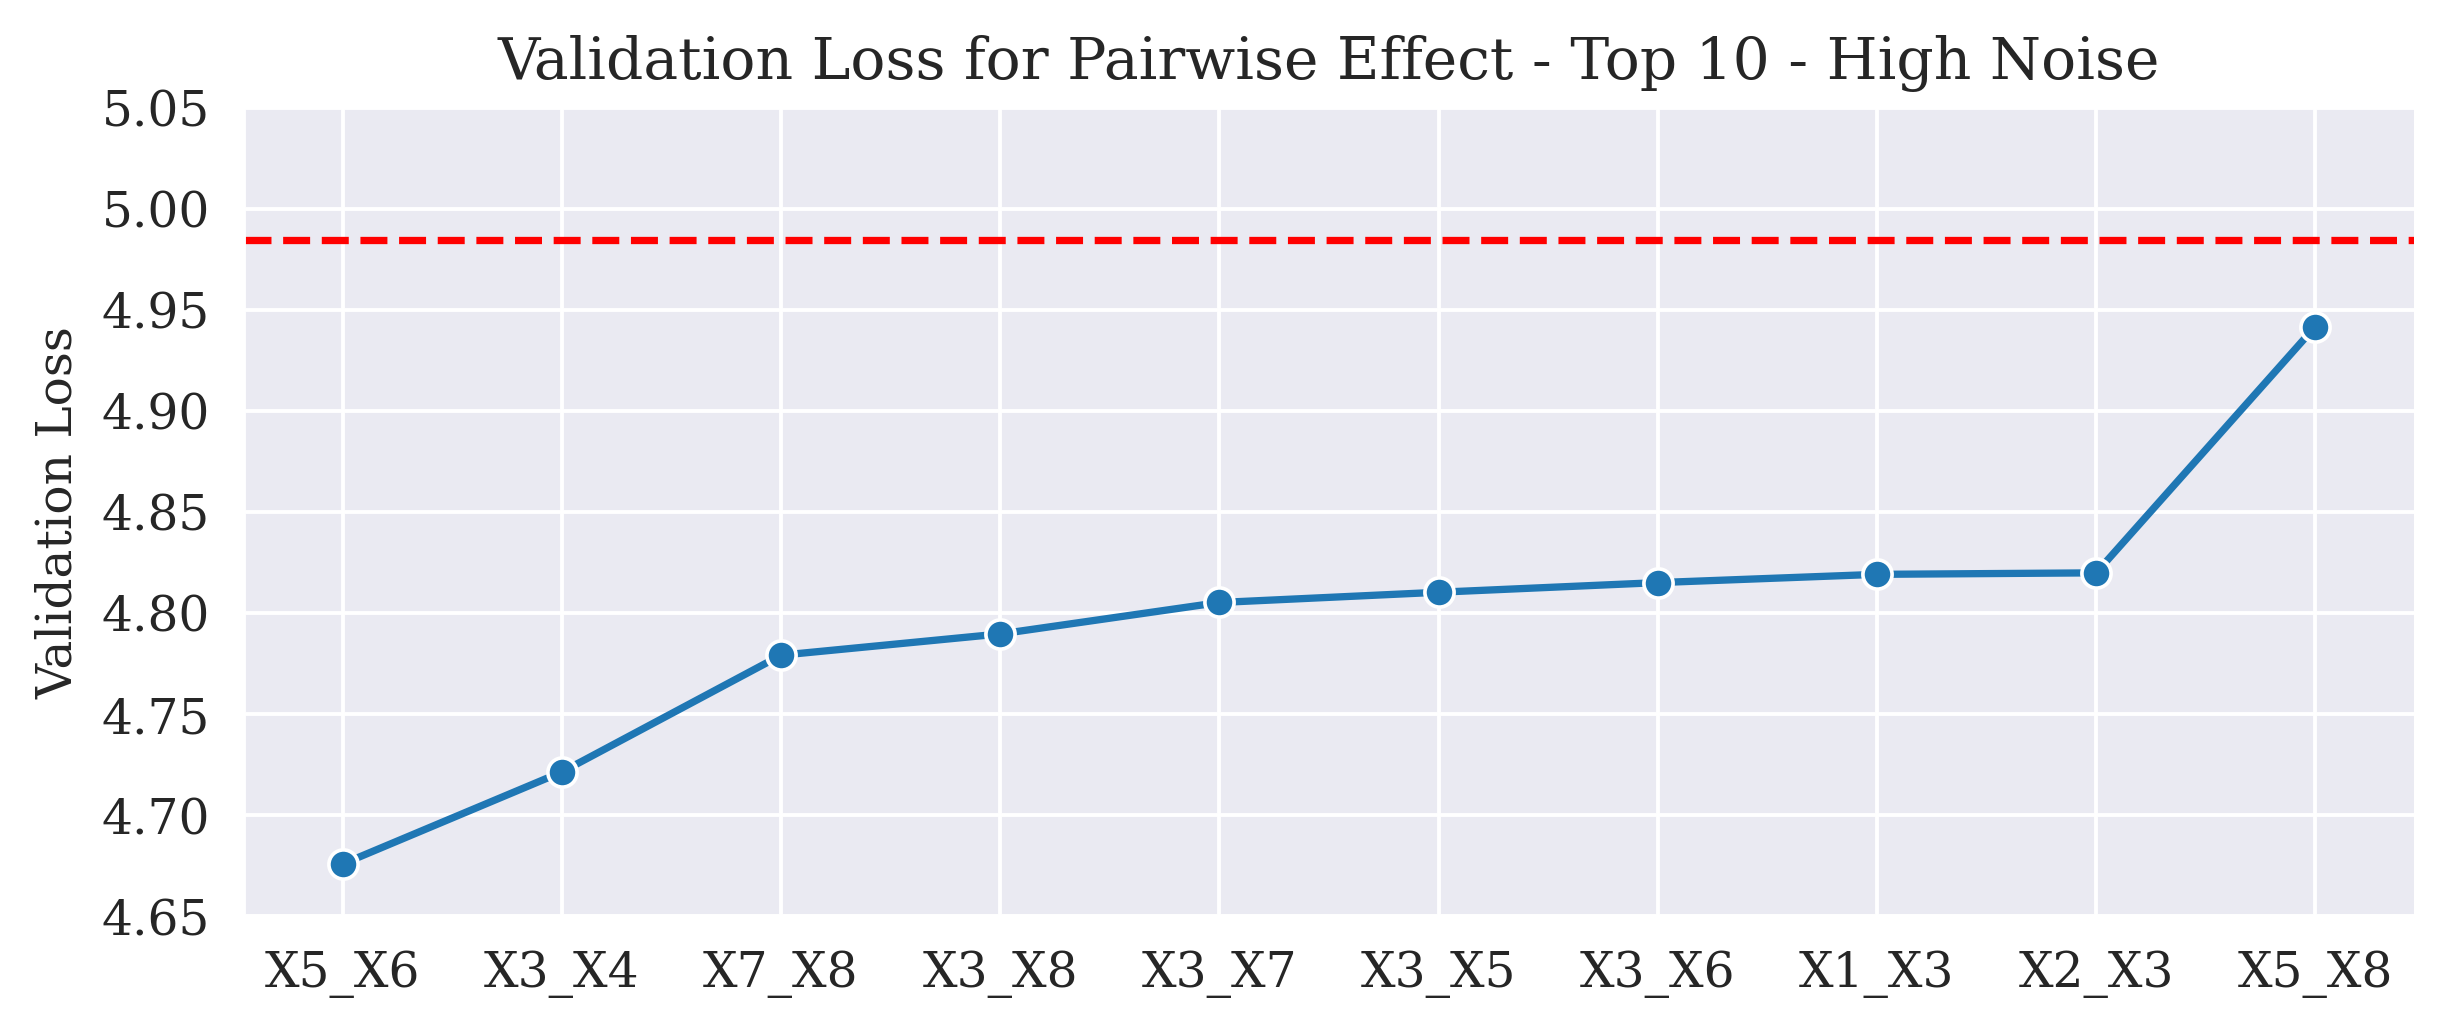

In [22]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)

# for presentation, select top k effect
interaction_df = interaction_df.head(10)

# Create the bar plot using Seaborn
# plt.figure(figsize = (12, 8))
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--')
plt.xlabel('')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Pairwise Effect - Top 10 - High Noise')
# plt.legend()

plt.rcParams["figure.figsize"] = (8, 3) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.ylim(4.65, 5.05)

plt.show()